In [1]:
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce t

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""
ECEN 743: Reinforcement Learning
Policy Gradient Assignment
Code tested using
	1. gymnasium 0.27.1
	2. box2d-py  2.3.5
	3. pytorch   2.0.0
	4. Python    3.9.12
1 & 2 can be installed using pip install gymnasium[box2d]
General Instructions
1. This code consists of TODO blocks, read them carefully and complete each of the blocks
2. Type your code between the following lines
			###### TYPE YOUR CODE HERE ######
			#################################
3. The default hyperparameters should be able to solve LunarLander-v2 in the continuous setting
4. It is not necessary to modify the rest of the code for this assignment, feel free to do so if needed.
"""
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import math
from collections import deque

class value_network(nn.Module):
	'''
	Value Network: Designed to take in state as input and give value as output
	Used as a baseline in Policy Gradient (PG) algorithms
	'''
	def __init__(self,state_dim):
		'''
			state_dim (int): state dimenssion
		'''
		super(value_network, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, 1)

	def forward(self,state):
		'''
		Input: State
		Output: Value of state
		'''
		v = F.tanh(self.l1(state))
		v = F.tanh(self.l2(v))
		return self.l3(v)


class policy_network(nn.Module):
	'''
	Policy Network: Designed for continous action space, where given a 
	state, the network outputs the mean and standard deviation of the action
	'''
	def __init__(self,state_dim,action_dim,log_std = 0.0):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
			log_std (float): log of standard deviation (std)
		"""
		super(policy_network, self).__init__()
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.l1 = nn.Linear(state_dim,64)
		self.l2 = nn.Linear(64,64)
		self.mean = nn.Linear(64,action_dim)
		self.log_std = nn.Parameter(torch.ones(1, action_dim) * log_std)

	
	def forward(self,state):
		'''
		Input: State
		Output: Mean, log_std and std of action
		'''
		a = F.tanh(self.l1(state))
		a = F.tanh(self.l2(a))
		a_mean = self.mean(a)
		a_log_std = self.log_std.expand_as(a_mean)
		a_std = torch.exp(a_log_std)		
		return a_mean, a_log_std, a_std

	def select_action(self, state):
		'''
		Input: State
		Output: Sample drawn from a normal disribution with mean and std
		'''
		a_mean, _, a_std = self.forward(state)
		action = torch.normal(a_mean, a_std)
		return action
	
	def get_log_prob(self, state, action):
		'''
		Input: State, Action
		Output: log probabilities
		'''
		mean, log_std, std = self.forward(state)
		var = std.pow(2)
		log_density = -(action - mean).pow(2) / (2 * var) - 0.5 * math.log(2 * math.pi) - log_std
		return log_density.sum(1, keepdim=True)

In [34]:
env.reset()

(array([ 9.3841554e-05,  1.4188634e+00,  9.4894525e-03,  3.5303608e-01,
        -1.0194965e-04, -2.1495181e-03,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

In [35]:
class PGAgent():
	'''
	An agent that performs different variants of the PG algorithm
	'''
	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 lr=1e-3,
	 gpu_index=0,
	 seed=0,
	 env="LunarLander-v2"
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			lr (float): learning rate
			gpu_index (int): GPU used for training
			seed (int): Seed of simulation
			env (str): Name of environment
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.lr = lr
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')
		self.env_name = env
		self.seed = seed
		self.policy = policy_network(state_dim,action_dim)
		self.value = value_network(state_dim)
		self.optimizer_policy = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
		self.optimizer_value = torch.optim.Adam(self.value.parameters(), lr=self.lr)

	def sample_traj(self,batch_size=2000,evaluate = False):
		'''
		Input: 
			batch_size: minimum batch size needed for update
			evaluate: flag to be set during evaluation
		Output:
			states, actions, rewards,not_dones, episodic reward 	
		'''
		self.policy.to("cpu") #Move network to CPU for sampling
		env = gym.make(args.env,continuous=True)
		states = []
		actions = []
		rewards = []
		n_dones = []
		curr_reward_list = []
		while len(states) < batch_size:
			state, _ = env.reset(seed=self.seed)
			curr_reward = 0
			for t in range(1000):
				state_ten = torch.from_numpy(state).float().unsqueeze(0)
				with torch.no_grad():
					if evaluate:
						action = self.policy(state_ten)[0][0].numpy() # Take mean action during evaluation
					else:
						action = self.policy.select_action(state_ten)[0].numpy() # Sample from distribution during training
				action = action.astype(np.float64)
				n_state,reward,terminated,truncated,_ = env.step(action) # Execute action in the environment
				done = terminated or truncated
				states.append(state)
				actions.append(action)
				rewards.append(reward)
				n_done = 0 if done else 1
				n_dones.append(n_done)
				state = n_state
				curr_reward += reward
				if done:
					break
			curr_reward_list.append(curr_reward)
		if evaluate:
			return np.mean(curr_reward_list)
		return states,actions,rewards,n_dones, np.mean(curr_reward_list)
	



	def update(self,states,actions,rewards,n_dones,update_type='Baseline'):
		'''
		TODO: Complete this block to update the policy using different variants of PG
		Inputs:
			states: list of states
			actions: list of actions
			rewards: list of rewards
			n_dones: list of not dones
			update_type: type of PG algorithm
		Output: 
			None
		'''
		self.policy.to(self.device) #Move policy to GPU
		if update_type == "Baseline":
			self.value.to(self.device)	#Move value to GPU
		states_ten = torch.from_numpy(np.stack(states)).to(self.device)   #Convert to tensor and move to GPU
		action_ten = torch.from_numpy(np.stack(actions)).to(self.device)  #Convert to tensor and move to GPU
		rewards_ten = torch.from_numpy(np.stack(rewards)).to(self.device) #Convert to tensor and move to GPU
		n_dones_ten = torch.from_numpy(np.stack(n_dones)).to(self.device) #Convert to tensor and move to GPU

		if update_type == "Rt":
				'''
				TODO: Peform PG using the cumulative discounted reward of the entire trajectory
				1. Compute the discounted reward of each trajectory (rt)
				2. rt should be of the same length as rewards_ten (refer to the homework for an exact formulation)
				3. Compute log probabilities using states_ten and action_ten
				4. Compute policy loss and update the policy
				'''
				rt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
				for t in reversed(range(rewards_ten.shape[0])):
					if t == rewards_ten.shape[0] - 1:
						rt[t] = rewards_ten[t]
					else:
						rt[t] = rewards_ten[t] + self.discount * rt[t+1] * n_dones_ten[t+1]
				#mean, std = self.forward(states)
				#dist = torch.distributions.Normal(mean, std)
				#log_probs = dist.log_prob(actions).sum(dim=1, keepdim=True)
				#action_probs = self.policy(states_ten)
				#log_probs = torch.log(action_probs.gather(1, action_ten.unsqueeze(1)).squeeze())
				
				log_probs = self.policy.get_log_prob(states_ten, action_ten)
				policy_loss = -torch.mean(log_probs * rt.detach())
				self.optimizer_policy.zero_grad()
				policy_loss.backward()
				self.optimizer_policy.step()

			###### TYPE YOUR CODE HERE ######
			# Do steps 1-4
			#################################
			
			#################################

		if update_type == 'Gt':
			'''
			TODO: Peform PG using reward_to_go
			1. Compute reward_to_go (gt) using rewards_ten and n_dones_ten
			2. gt should be of the same length as rewards_ten
			3. Compute log probabilities using states_ten and action_ten
			4. Compute policy loss and update the policy
			'''
			def compute_reward_to_go(rewards, discount):
				'''
				Computes reward-to-go for a given list of rewards and discount factor

				Inputs:
					rewards (list): list of rewards
					discount (float): discount factor

				Output:
					rtg (list): list of reward-to-go
				'''
				rtg = [rewards[-1]]
				for i in range(len(rewards) - 2, -1, -1):
					rtg.insert(0, rewards[i] + discount * rtg[0])
				return rtg
				
			gt = torch.zeros(rewards_ten.shape[0],1).to(self.device)

			###### TYPE YOUR CODE HERE ######

			num_t = 1
			cumulative = 0
			for t in reversed(range(rewards_ten.shape[0])):
				if n_dones[t]==0:
					num_t += 1
				cumulative = (self.discount*cumulative*(n_dones_ten[t]) + rewards_ten[t])
				gt[t] = cumulative

			gt = (gt - gt.mean()) / gt.std() #Helps with learning stablity
			log_probs = self.policy.get_log_prob(states_ten,action_ten)
			policy_loss = -torch.sum(torch.mul(log_probs,gt))/num_t
			self.optimizer_policy.zero_grad()
			policy_loss.backward()
			self.optimizer_policy.step()
   
			###### TYPE YOUR CODE HERE ######
			# Compute log probabilities and update the policy
			#################################

		if update_type == 'Baseline':
			'''
			TODO: Peform PG using reward_to_go and baseline
			1. Compute values of states, this will be used as the baseline 
			2. Compute reward_to_go (gt) using rewards_ten and n_dones_ten
			3. gt should be of the same length as rewards_ten
			4. Compute advantages 
			5. Update the value network to predict gt for each state (L2 norm)
			6. Compute log probabilities using states_ten and action_ten
			7. Compute policy loss (using advantages) and update the policy
			'''
			with torch.no_grad():
				values_adv = self.value(states_ten)
			gt = torch.zeros(rewards_ten.shape[0],1).to(self.device)

			###### TYPE YOUR CODE HERE ######
			# Compute reward_to_go (gt) and advantages
			num_t = 1
			cumulative = 0
			for t in reversed(range(rewards_ten.shape[0])):
				if n_dones[t]==0:
					num_t += 1
				cumulative = (self.discount*cumulative*(n_dones_ten[t]) + rewards_ten[t])
				gt[t] = cumulative

			advantages = gt - values_adv
			advantages = (advantages - advantages.mean()) / advantages.std()

			###### TYPE YOUR CODE HERE ######
			# Do steps 5-7
			value_loss = F.mse_loss(gt,self.value(states_ten))
			self.optimizer_value.zero_grad()
			value_loss.backward()
			self.optimizer_value.step()
			log_probs = self.policy.get_log_prob(states_ten,action_ten)
			policy_loss = -torch.sum(torch.mul(log_probs,advantages))/num_t
			self.optimizer_policy.zero_grad()
			policy_loss.backward()
			self.optimizer_policy.step()


if __name__ == "__main__":
	parser = argparse.ArgumentParser()
	parser.add_argument("--env", default="LunarLander-v2")		 # Gymnasium environment name
	parser.add_argument("--seed", default=0, type=int)               # Sets Gym, PyTorch and Numpy seeds
	parser.add_argument("--n-iter", default=200, type=int)   # 200         # Maximum number of training iterations
	parser.add_argument("--discount", default=0.99)              # 0.99    # Discount factor
	parser.add_argument("--batch-size", default=5000, type=int)   # 5000   # 10000 # Training samples in each batch of training
	parser.add_argument("--lr", default=0.005,type=float)         # 5e-3 # 5e-2  # 1e-2 #   # Learning rate
	parser.add_argument("--gpu-index", default=0,type=int)		 # GPU index
	parser.add_argument("--algo", default="Baseline",type=str)  # Baseline      # PG algorithm type. Baseline/Gt/Rt
	args = parser.parse_args(args=[])   # I added args=[] #

	# Making the environment	
	env = gym.make(args.env, continuous=True, render_mode = 'rgb_array') # 


	#from gym import wrappers
	#env = wrappers.RecordVideo(gym.make('LunarLanderContinuous-v2'), force=True)


	state_dim = env.observation_space.shape[0]
	action_dim = env.action_space.shape[0]

	#env = gym.make(args.env,render_mode="rgb_array_list")
	#env = gym.wrappers.RecordVideo(env=env, step_trigger = 10, video_folder='./video')
 
	# Setting seeds
	torch.manual_seed(args.seed)
	np.random.seed(args.seed)
	random.seed(args.seed)


	kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":args.discount,
		"lr":args.lr,
		"gpu_index":args.gpu_index,
		"seed":args.seed,
		"env":args.env
	}	
	learner = PGAgent(**kwargs) # Creating the PG learning agent

	moving_window = deque(maxlen=10)
 
	smoothened_cumulative_reward_history = [] ##################################################### Abhi 
	smoothened_cumulative_reward_history_train = [] ##################################################### Abhi
	consistency_count = 0	 ##################################################### Abhi

	for e in range(args.n_iter):
		'''
		Steps of PG algorithm
			1. Sample environment to gather data using a policy
			2. Update the policy using the data
			3. Evaluate the updated policy
			4. Repeat 1-3
		'''

		states,actions,rewards,n_dones,train_reward = learner.sample_traj(batch_size=args.batch_size)
		learner.update(states,actions,rewards,n_dones,args.algo)
		eval_reward= learner.sample_traj(evaluate=True)
		moving_window.append(eval_reward)
		print('Training Iteration {} Training Reward: {:.2f} Evaluation Reward: {:.2f} \
		Average Evaluation Reward: {:.2f}'.format(e,train_reward,eval_reward,np.mean(moving_window)))
		
		smoothened_cumulative_reward_history_train.append(train_reward)
		smoothened_cumulative_reward_history.append(np.mean(moving_window))
		if np.mean(moving_window)>=200.:
			consistency_count += 1
			if consistency_count == 100:
				torch.save(learner.Q.state_dict(),'./model.ckpt')
				break
		else:
			consistency_count = 0
		
		"""
		TODO: Write code for
		1. Logging and plotting
		2. Rendering the trained agent 
		"""
		###### TYPE YOUR CODE HERE ######
		#################################
		import os
		import imageio
		import numpy as np
		from PIL import Image
		import PIL.ImageDraw as ImageDraw
		import matplotlib.pyplot as plt    


		def _label_with_episode_number(frame, episode_num):
			im = Image.fromarray(frame)

			drawer = ImageDraw.Draw(im)

			if np.mean(im) < 128:
				text_color = (255,255,255)
			else:
				text_color = (0,0,0)
			drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

			return im


		def save_random_agent_gif(env):
			img = []
			for episodic in range(1):
				state, x = env.reset()

				while True:
					state = torch.from_numpy(state).float().unsqueeze(0)
					action = learner.policy(state)[0].detach().squeeze(0).numpy()
					next_state, r, tr, te, i = env.step(action)

					#display.clear_output(wait = True)
					img.append(env.render())
					state = next_state
					if tr or te:
						break

			env.close()
			imageio.mimwrite(os.path.join('drive/MyDrive/Ph. D. Coursework/ECEN743_ReinforcementLearning/A5/videos/', 'lunar_lander_BL.gif'), img, fps=60)
	 
	#env = gym.make("LunarLander-v2", continuous = True, render_mode = 'rgb_array')
	save_random_agent_gif(env)

Training Iteration 0 Training Reward: -80.02 Evaluation Reward: -291.59 		Average Evaluation Reward: -291.59
Training Iteration 1 Training Reward: -233.58 Evaluation Reward: -545.55 		Average Evaluation Reward: -418.57
Training Iteration 2 Training Reward: -220.12 Evaluation Reward: -215.12 		Average Evaluation Reward: -350.75
Training Iteration 3 Training Reward: -142.39 Evaluation Reward: -217.00 		Average Evaluation Reward: -317.32
Training Iteration 4 Training Reward: -93.55 Evaluation Reward: -217.58 		Average Evaluation Reward: -297.37
Training Iteration 5 Training Reward: -115.88 Evaluation Reward: -119.50 		Average Evaluation Reward: -267.72
Training Iteration 6 Training Reward: -57.48 Evaluation Reward: -285.43 		Average Evaluation Reward: -270.25
Training Iteration 7 Training Reward: -30.86 Evaluation Reward: -3.71 		Average Evaluation Reward: -236.94
Training Iteration 8 Training Reward: -45.42 Evaluation Reward: -201.72 		Average Evaluation Reward: -233.02
Training Iteratio

In [ ]:
#save_random_agent_gif(env)

In [7]:
def _label_with_episode_number(frame, episode_num):
	im = Image.fromarray(frame)

	drawer = ImageDraw.Draw(im)

	if np.mean(im) < 128:
		text_color = (255,255,255)
	else:
		text_color = (0,0,0)
	drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

	return im


def save_random_agent_gif(env):
	img = []
	for episodic in range(1):
		state, x = env.reset()

		while True:
			state = torch.from_numpy(state).float().unsqueeze(0)
			action = learner.policy(state)[0].detach().squeeze(0).numpy()
			next_state, r, tr, te, i = env.step(action)

			display.clear_output(wait = True)
			img.append(env.render())
			state = next_state
			if tr or te:
				break

	env.close()
	imageio.mimwrite(os.path.join('My Drive/Ph. D. Coursework/ECEN743_ReinforcementLearning/A5/videos/', 'lunar_lander_RT.gif'), img, fps=60)

Text(0, 0.5, 'Episodic Undiscounted-cumulative Reward')

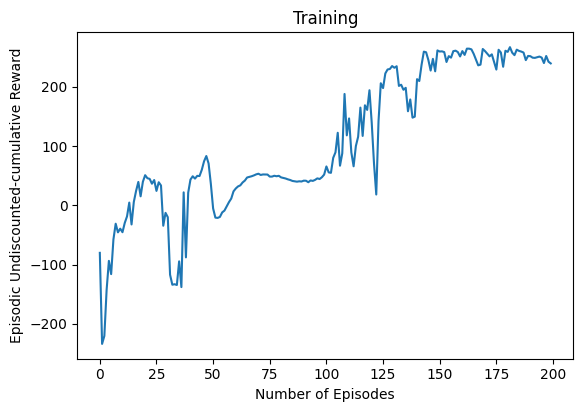

In [36]:
# now that training has finished, we can plot cumulative reward vs episodes
import pickle
from matplotlib import pyplot as plt
#pickle.dump(eval_reward, open('cum_rwe','wb'))
plt.subplots_adjust(bottom=0.2)
plt.plot(smoothened_cumulative_reward_history_train)
plt.title('Training')
plt.xlabel('Number of Episodes')
plt.ylabel('Episodic Undiscounted-cumulative Reward')
#plt.ylim([-1000, 1000])
#plt.xlim([0, 500])

Text(0, 0.5, 'Episodic Undiscounted-cumulative Reward')

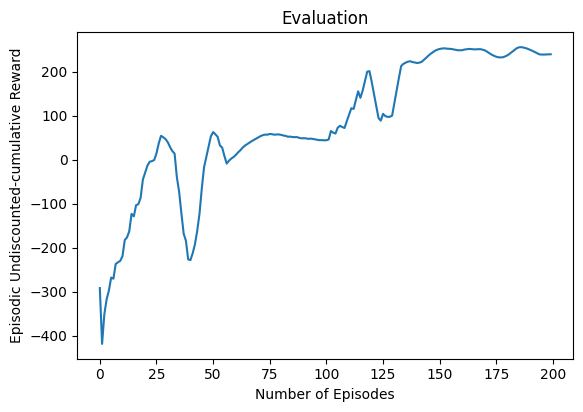

In [37]:
# now that training has finished, we can plot cumulative reward vs episodes
import pickle
from matplotlib import pyplot as plt
#pickle.dump(eval_reward, open('cum_rwe','wb'))
plt.subplots_adjust(bottom=0.2)
plt.plot(smoothened_cumulative_reward_history)
plt.title('Evaluation')
plt.xlabel('Number of Episodes')
plt.ylabel('Episodic Undiscounted-cumulative Reward')
#plt.ylim([-1000, 1000])
#plt.xlim([0, 500])

In [ ]:
import os
import imageio
import numpy as np
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt    


def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

    return im


def save_random_agent_gif(env):
    img = []
    for episodic in range(1):
        state, x = env.reset()

        while True:
            state = torch.from_numpy(state).float().unsqueeze(0)
            action = learner.policy(state)[0].detach().squeeze(0).numpy()
            next_state, r, tr, te, i = env.step(action)

            display.clear_output(wait = True)
            img.append(env.render())
            state = next_state
            if tr or te:
                break


    env.close()

    imageio.mimwrite(os.path.join('./video/', 'random_agent.gif'), img, fps=60)

In [ ]:
env = gym.make("LunarLander-v2", continuous = True, render_mode = 'rgb_array')
save_random_agent_gif(env)

In [ ]:
! pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation
seed = 12345

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

d = Display()
d.start()

env = gym.make("LunarLander-v2", continuous = True, render_mode = 'rgb_array')

img = []
for episodic in range(1):
    state, x = env.reset()

    while True:
        state = torch.from_numpy(state).float().unsqueeze(0)
        action = learner.policy(state)[0].detach().squeeze(0).numpy()
        next_state, r, tr, te, i = env.step(action)

        display.clear_output(wait = True)
        img.append(env.render())
        state = next_state
        if tr or te:
            break

dpi = 72
interval = 50 #ms

plt.figure(figsize = (img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi = dpi)
patch = plt.imshow(img[0])
plt.axis = ("off")
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(), animate, frames = len(img), interval = interval)
display.display(display.HTML(ani.to_jshtml()))

writervideo = animation.FFMpegWriter(fps = 30)
ani.save('baselineLunar.mp4', writer = writervideo)
plt.close()

In [ ]:
# 10 min 1 second for Rt
# 10 min 24 seconds for Gt
# 10 min 19 seconds for Baseline